# An Investigation Into Gauss Markov Assumptions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    OneHotEncoder, PolynomialFeatures, StandardScaler)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import seaborn as sns
from sklearn.model_selection import (
    cross_val_score, KFold, train_test_split,
    cross_validate, ShuffleSplit)
import scipy.stats as stats
from itertools import combinations
import statsmodels.api as sm
from statsmodels.regression import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import scipy.stats
import random

In [2]:
og_df = pd.read_csv('data/kc_house_data.csv')

In [3]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Clean

In [4]:
og_df['waterfront'].fillna(0.0,inplace=True)

In [5]:
og_df['view'].fillna(0.0,inplace=True)

In [6]:
vals = []
for i in range(len(og_df)):
    if np.isnan(og_df['yr_renovated'].iloc[i]):
        vals.append(0)
    elif og_df['yr_renovated'].iloc[i] == 0:
        vals.append(0)
    elif og_df['yr_renovated'].iloc[i] > 0:
        vals.append(1)
        

In [7]:
og_df['is_renovated'] = vals

In [8]:
og_df = og_df.drop(columns=['yr_renovated'])

In [9]:
og_df['date'] = og_df['date'].astype(object)

In [10]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  float64
 9   view           21597 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

# Train Test Split

In [11]:
y = og_df['price']
X = og_df.drop(columns = 'price')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16197, 20), (5400, 20), (16197,), (5400,))

# Correlation Inspection

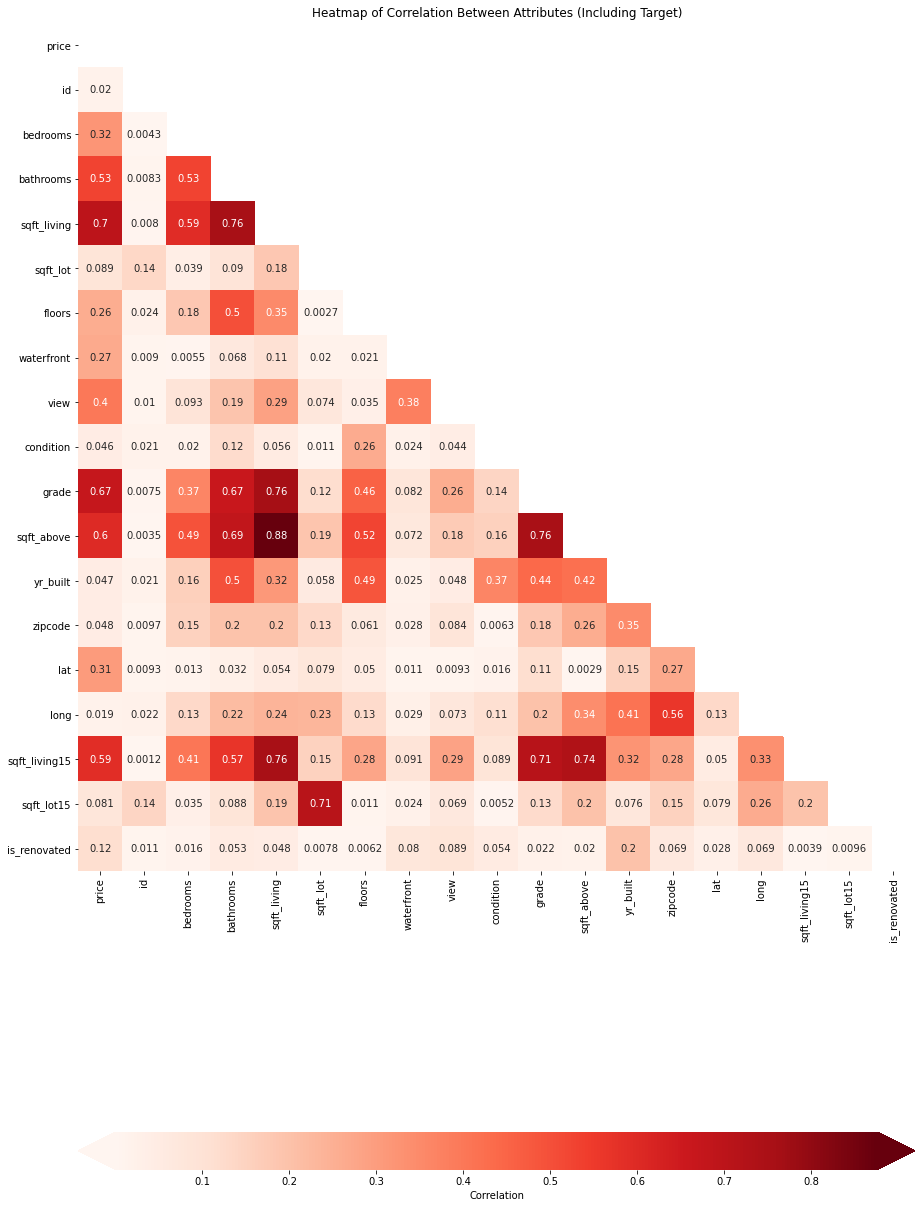

In [12]:
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr().abs()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 24))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    cmap='Reds',
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");



# Baseline Model

In [13]:
#Most Correlated Features to Price
cor = og_df.corr()
cor_target = abs(corr['price'])
relevant_features = cor_target[cor_target>.5]
relevant_features

price            1.000000
bathrooms        0.529906
sqft_living      0.700397
grade            0.671702
sqft_above       0.601355
sqft_living15    0.591150
Name: price, dtype: float64

In [14]:
most_correlated_features = ['sqft_living', 'bathrooms', 'grade']

In [15]:
baseline_model = LinearRegression()
baseline_model.fit(X_train[most_correlated_features], y_train)
y_pred_train = baseline_model.predict(X_train[most_correlated_features])
y_pred_test = baseline_model.predict(X_test[most_correlated_features])

#R^2
baseline_r_train = baseline_model.score(X_train[most_correlated_features], y_train)
baseline_r_test = baseline_model.score(X_test[most_correlated_features], y_test)
#MAE
baseline_mae_train = mean_absolute_error(y_train, y_pred_train)
baseline_mae_test = mean_absolute_error(y_test, y_pred_test)

In [16]:
print("Baseline Model")
print("R^2 for train:", baseline_r_train)
print("R^2 for test:", baseline_r_test)
print("MAE for train:", baseline_mae_train)
print("MAE for test:", baseline_mae_test)

Baseline Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446794
MAE for train: 163935.8173393085
MAE for test: 162201.2435837135


In [17]:
X = sm.add_constant(X_train[most_correlated_features])
baseline_sum = sm.OLS(y_train, X).fit()
baseline_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6292.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:51:02   Log-Likelihood:            -2.2423e+05
No. Observations:               16197   AIC:                         4.485e+05
Df Residuals:                   16193   BIC:                         4.485e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.212e+05   1.53e+04    -40.469      0.000   -6.51e+05   -5.91e+05
sqft_living   197.4547      3.857     51.190      0.000     189.894     205.015
bathrooms   -3.587e+04   4000.168     -8.967      0.000   -4.37e+04    -2.8e+04
grade         1.08e+05   2639.922     40.901      0.000    1.03e+05    1.13e+05
==============================================================================
Omnibus:                    11793.849   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           503921.998
Skew:                           3.036   Prob(JB):                         0.00
Kurtosis:                      29.642   Cond. No.                     1.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
1.08e+05

108000.0

<ipython-input-19-5ed29d78fedd>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


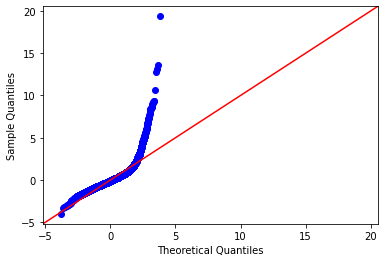

In [19]:
residuals = baseline_sum.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, 
                        line = '45', fit=True)
fig.show()

# Linearity:
The parameters we are estimating using the OLS method must be themselves linear.
source(https://www.statisticshowto.com/gauss-markov-theorem-assumptions/)

In [20]:
cor = og_df.corr()
cor_target = abs(corr['price'])
cor_target[cor_target<.25]


id              0.019919
sqft_lot        0.089019
condition       0.046139
yr_built        0.046835
zipcode         0.047865
long            0.019459
sqft_lot15      0.080682
is_renovated    0.116289
Name: price, dtype: float64

## I will add the long variable to our independent variables to the baseline model to see how the model is affected.

Text(0, 0.5, 'Price (USD)')

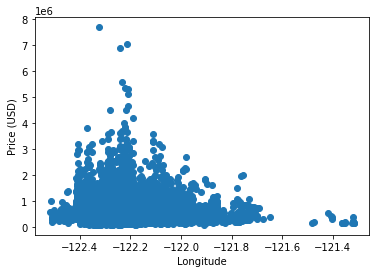

In [21]:
plt.scatter(x=og_df['long'],y=og_df['price'])
plt.xlabel('Longitude')
plt.ylabel('Price (USD)')

In [22]:
non_linear_feat = most_correlated_features
non_linear_feat.append('long')

In [23]:
non_linear_feat

['sqft_living', 'bathrooms', 'grade', 'long']

In [24]:
non_linear_model = LinearRegression()
non_linear_model.fit(X_train[non_linear_feat], y_train)
y_pred_train = non_linear_model.predict(X_train[non_linear_feat])
y_pred_test = non_linear_model.predict(X_test[non_linear_feat])

#R^2
non_linear_r_train = non_linear_model.score(X_train[non_linear_feat], y_train)
non_linear_r_test = non_linear_model.score(X_test[non_linear_feat], y_test)
#MAE
non_linear_mae_train = mean_absolute_error(y_train, y_pred_train)
non_linear_mae_test = mean_absolute_error(y_test, y_pred_test)

In [25]:
print("Baseline Model")
print("R^2 for train:", baseline_r_train)
print("R^2 for test:", baseline_r_test)
print("MAE for train:", baseline_mae_train)
print("MAE for test:", baseline_mae_test)

print("Non-Linear Model")
print("R^2 for train:", non_linear_r_train)
print("R^2 for test:", non_linear_r_test)
print("MAE for train:", non_linear_mae_train)
print("MAE for test:", non_linear_mae_test)

Baseline Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446794
MAE for train: 163935.8173393085
MAE for test: 162201.2435837135
Non-Linear Model
R^2 for train: 0.5627782214660296
R^2 for test: 0.5559327168774042
MAE for train: 159179.28217524564
MAE for test: 157539.58707101803


In [26]:
X = sm.add_constant(X_train[non_linear_feat])
non_linear_sum = sm.OLS(y_train, X).fit()
non_linear_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     5210.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:51:03   Log-Likelihood:            -2.2379e+05
No. Observations:               16197   AIC:                         4.476e+05
Df Residuals:                   16192   BIC:                         4.476e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.174e+07    1.7e+06    -30.495      0.000   -5.51e+07   -4.84e+07
sqft_living   207.6034      3.769     55.086      0.000     200.216     214.991
bathrooms    -2.95e+04   3898.388     -7.568      0.000   -3.71e+04   -2.19e+04
grade        1.093e+05   2569.329     42.527      0.000    1.04e+05    1.14e+05
long        -4.179e+05   1.39e+04    -30.130      0.000   -4.45e+05   -3.91e+05
==============================================================================
Omnibus:                    11414.263   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           480980.844
Skew:                           2.890   Prob(JB):                         0.00
Kurtosis:                      29.063   Cond. No.                     2.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
-4.179e+05	

-417900.0

<ipython-input-28-ec0db1a128b5>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


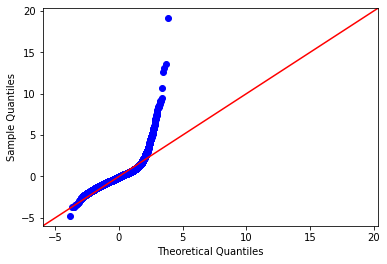

In [28]:
residuals = non_linear_sum.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, 
                        line = '45', fit=True)
fig.show()

# Random:
The data must have been randomly sampled from the population.

## I will remove all houses except those within a certain sqft range.

In [29]:
og_df.sqft_living.min()

370

In [30]:
og_df.sqft_living.max()

13540

# Train Test Split With Non-Random Data

In [31]:
subset = og_df.loc[(og_df['sqft_living'] < 5000) & 
              (og_df['sqft_living'] > 4000)]
y = subset.price
X = subset.drop(columns = 'price')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((425, 20), (142, 20), (425,), (142,))

In [32]:
most_correlated_features = ['sqft_living', 'bathrooms', 'grade']

For the sake of this investigation I will use the same features as the baseline model.

In [33]:
non_random_model = LinearRegression()
non_random_model.fit(X_train[most_correlated_features], y_train)
y_pred_train = non_random_model.predict(X_train[most_correlated_features])
y_pred_test = non_random_model.predict(X_test[most_correlated_features])

#R^2
non_random_r_train = non_random_model.score(X_train[most_correlated_features], y_train)
non_random_r_test = non_random_model.score(X_test[most_correlated_features], y_test)
#MAE
non_random_mae_train = mean_absolute_error(y_train, y_pred_train)
non_random_mae_test = mean_absolute_error(y_test, y_pred_test)

In [34]:
print("Baseline Model")
print("R^2 for train:", baseline_r_train)
print("R^2 for test:", baseline_r_test)
print("MAE for train:", baseline_mae_train)
print("MAE for test:", baseline_mae_test)

print("Non-Random Model")
print("R^2 for train:", non_random_r_train)
print("R^2 for test:", non_random_r_test)
print("MAE for train:", non_random_mae_train)
print("MAE for test:", non_random_mae_test)

Baseline Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446794
MAE for train: 163935.8173393085
MAE for test: 162201.2435837135
Non-Random Model
R^2 for train: 0.11562199028406395
R^2 for test: 0.2171999132225828
MAE for train: 436446.7046323092
MAE for test: 438783.89891409536


In [35]:
X = sm.add_constant(X_train[most_correlated_features])
non_random_sum = sm.OLS(y_train, X).fit()
non_random_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     18.35
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           3.32e-11
Time:                        17:51:03   Log-Likelihood:                -6231.0
No. Observations:                 425   AIC:                         1.247e+04
Df Residuals:                     421   BIC:                         1.249e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.407e+06   5.12e+05     -2.749      0.006   -2.41e+06   -4.01e+05
sqft_living   188.2528    113.455      1.659      0.098     -34.756     411.262
bathrooms     1.14e+05   4.57e+04      2.492      0.013    2.41e+04    2.04e+05
grade         1.52e+05   2.61e+04      5.827      0.000    1.01e+05    2.03e+05
==============================================================================
Omnibus:                       87.545   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.766
Skew:                           1.276   Prob(JB):                     2.71e-31
Kurtosis:                       4.199   Cond. No.                     8.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
1.52e+05

152000.0

<ipython-input-37-306e38a970e2>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


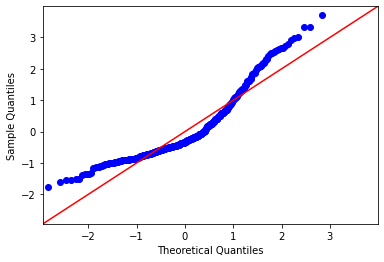

In [37]:
residuals = non_random_sum.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, 
                        line = '45', fit=True)
fig.show()

# Non-Collinearity
The regressors being calculated aren't perfectly correlated with each other.

# Train Test Split

In [38]:
og_df['grade_repeated'] = og_df['grade']+2

In [39]:
y = og_df['price']
X = og_df.drop(columns = 'price')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16197, 21), (5400, 21), (16197,), (5400,))

In [40]:
collinear_feats = most_correlated_features
collinear_feats.append('grade_repeated')

In [41]:
collinear_feats

['sqft_living', 'bathrooms', 'grade', 'grade_repeated']

In [42]:
collinear_model = LinearRegression()
collinear_model.fit(X_train[collinear_feats], y_train)
y_pred_train = collinear_model.predict(X_train[collinear_feats])
y_pred_test = collinear_model.predict(X_test[collinear_feats])

#R^2
collinear_r_train = collinear_model.score(X_train[collinear_feats], y_train)
collinear_r_test = collinear_model.score(X_test[collinear_feats], y_test)
#MAE
collinear_mae_train = mean_absolute_error(y_train, y_pred_train)
collinear_mae_test = mean_absolute_error(y_test, y_pred_test)

In [43]:
print("Baseline Model")
print("R^2 for train:", baseline_r_train)
print("R^2 for test:", baseline_r_test)
print("MAE for train:", baseline_mae_train)
print("MAE for test:", baseline_mae_test)

print("Collinear Model")
print("R^2 for train:", collinear_r_train)
print("R^2 for test:", collinear_r_test)
print("MAE for train:", collinear_mae_train)
print("MAE for test:", collinear_mae_test)

Baseline Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446794
MAE for train: 163935.8173393085
MAE for test: 162201.2435837135
Collinear Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446856
MAE for train: 163935.81733933307
MAE for test: 162201.2435837383


In [44]:
X = sm.add_constant(X_train[collinear_feats])
collinear_sum = sm.OLS(y_train, X).fit()
collinear_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6292.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:51:03   Log-Likelihood:            -2.2423e+05
No. Observations:               16197   AIC:                         4.485e+05
Df Residuals:                   16193   BIC:                         4.485e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.431e+05   5941.414    -40.908      0.000   -2.55e+05   -2.31e+05
sqft_living      197.4547      3.857     51.190      0.000     189.894     205.015
bathrooms      -3.587e+04   4000.168     -8.967      0.000   -4.37e+04    -2.8e+04
grade            2.97e+05   7203.212     41.237      0.000    2.83e+05    3.11e+05
grade_repeated -1.891e+05   4711.594    -40.128      0.000   -1.98e+05    -1.8e+05
==============================================================================
Omnibus:                    11793.849   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           503921.998
Skew:                           3.036   Prob(JB):                         0.00
Kurtosis:                      29.642   Cond. No.                     3.14e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.5e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [70]:
-1.891e+05

-189100.0

<ipython-input-45-2280026ce2cf>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


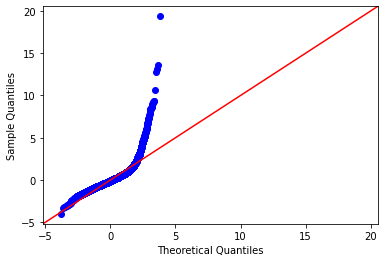

In [45]:
residuals = collinear_sum.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, 
                        line = '45', fit=True)
fig.show()

In [46]:
def check_collin(feats, df):
    """
    IN: feats is the independent variable(s), df is the dataframe
    
    OUT: Dictionary containing feature name and variance inflaction factor
    score. If the score is > 10 it is unuseable
    
    """
    vif_dct = {}
    X_train_consts = sm.add_constant(df[feats])
    for i in range(len(X_train_consts.columns)):
    
        vif = variance_inflation_factor(X_train_consts.values, i)
        v = X_train_consts.columns[i]
        vif_dct[v] = vif
    return vif_dct

In [47]:
check_collin(collinear_feats, X_train)

/Users/johnwelsh/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/johnwelsh/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'const': 0.0,
 'sqft_living': 3.2779742999253285,
 'bathrooms': 2.46654792418915,
 'grade': inf,
 'grade_repeated': inf}

# Exogeneity:
The regressors aren't correlated with the error term

For this experiment I will switch price and sqft_living.

## Train Test Split

In [48]:
y = og_df['sqft_living']
X = og_df.drop(columns = 'sqft_living')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16197, 21), (5400, 21), (16197,), (5400,))

In [49]:
most_correlated_features.pop()

'grade_repeated'

In [50]:
most_correlated_features.pop(0)

'sqft_living'

In [51]:
most_correlated_features.append('price')

In [52]:
most_correlated_features

['bathrooms', 'grade', 'price']

In [53]:
exog_model = LinearRegression()
exog_model.fit(X_train[most_correlated_features], y_train)
y_pred_train = exog_model.predict(X_train[most_correlated_features])
y_pred_test = exog_model.predict(X_test[most_correlated_features])

#R^2
exog_r_train = exog_model.score(X_train[most_correlated_features], y_train)
exog_r_test = exog_model.score(X_test[most_correlated_features], y_test)
#MAE
exog_mae_train = mean_absolute_error(y_train, y_pred_train)
exog_mae_test = mean_absolute_error(y_test, y_pred_test)

In [54]:
print("Baseline Model")
print("R^2 for train:", baseline_r_train)
print("R^2 for test:", baseline_r_test)
print("MAE for train:", baseline_mae_train)
print("MAE for test:", baseline_mae_test)

print("Exog Model")
print("R^2 for train:", exog_r_train)
print("R^2 for test:", exog_r_test)
print("MAE for train:", exog_mae_train)
print("MAE for test:", exog_mae_test)

Baseline Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446794
MAE for train: 163935.8173393085
MAE for test: 162201.2435837135
Exog Model
R^2 for train: 0.7374243651822724
R^2 for test: 0.7365186556517289
MAE for train: 353.3501693741651
MAE for test: 355.36531608310344


In [55]:
X = sm.add_constant(X_train[most_correlated_features])
exog_sum = sm.OLS(y_train, X).fit()
exog_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sqft_living   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                 1.516e+04
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:51:04   Log-Likelihood:            -1.2266e+05
No. Observations:               16197   AIC:                         2.453e+05
Df Residuals:                   16193   BIC:                         2.453e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1139.3070     29.098    -39.154      0.000   -1196.342   -1082.272
bathrooms    491.3205      6.522     75.329      0.000     478.536     504.105
grade        235.2013      4.904     47.957      0.000     225.588     244.814
price          0.0007   1.38e-05     51.190      0.000       0.001       0.001
==============================================================================
Omnibus:                     2324.781   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11052.686
Skew:                           0.621   Prob(JB):                         0.00
Kurtosis:                       6.852   Cond. No.                     5.21e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-56-e82a4e635d52>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


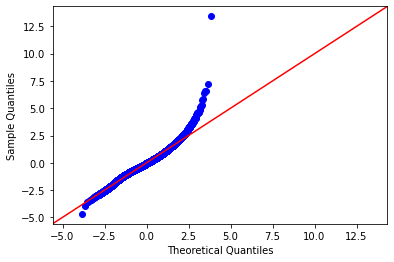

In [56]:
residuals = exog_sum.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, 
                        line = '45', fit=True)
fig.show()

In [57]:
check_collin(most_correlated_features, X_train)

{'const': 61.934766279085416,
 'bathrooms': 1.8355601301892024,
 'grade': 2.405417256145229,
 'price': 1.8640930449493154}

https://stats.stackexchange.com/a/59639

# Homoscedasticity:
No matter what the values of our regressors might be, the error of the variance is constant.

## Train Test Split

In [58]:
y = og_df['price']
X = og_df.drop(columns = 'price')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16197, 21), (5400, 21), (16197,), (5400,))

In [59]:
most_correlated_features = ['sqft_living', 'bathrooms', 'grade']

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

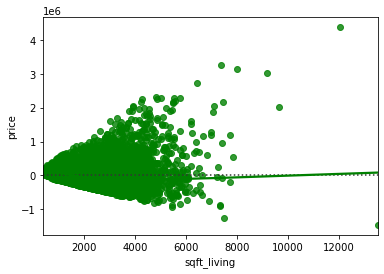

In [60]:
sns.residplot(x=X_train['sqft_living'], y=y_train, lowess=True, color="g")

In [61]:
heteroscedastic_model = LinearRegression()
heteroscedastic_model.fit(X_train[most_correlated_features], y_train)
y_pred_train = heteroscedastic_model.predict(X_train[most_correlated_features])
y_pred_test = heteroscedastic_model.predict(X_test[most_correlated_features])

#R^2
heteroscedastic_r_train = heteroscedastic_model.score(X_train[most_correlated_features], y_train)
heteroscedastic_r_test = heteroscedastic_model.score(X_test[most_correlated_features], y_test)
#MAE
heteroscedastic_mae_train = mean_absolute_error(y_train, y_pred_train)
heteroscedastic_mae_test = mean_absolute_error(y_test, y_pred_test)

## Train Test Split

In [62]:
subset = og_df.loc[og_df.price < 1_000_000]
y = subset['price']
X = subset.drop(columns = 'price')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15080, 21), (5027, 21), (15080,), (5027,))

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

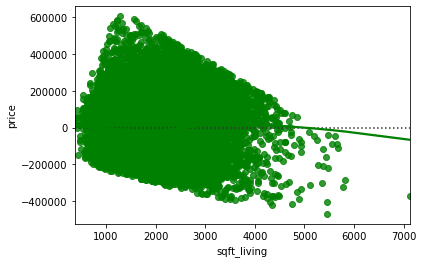

In [63]:
sns.residplot(x=X_train['sqft_living'], y=y_train, lowess=True, color="g")

In [64]:
homoscedastic_model = LinearRegression()
homoscedastic_model.fit(X_train[most_correlated_features], y_train)
y_pred_train = homoscedastic_model.predict(X_train[most_correlated_features])
y_pred_test = homoscedastic_model.predict(X_test[most_correlated_features])

#R^2
homoscedastic_r_train = homoscedastic_model.score(X_train[most_correlated_features], y_train)
homoscedastic_r_test = homoscedastic_model.score(X_test[most_correlated_features], y_test)
#MAE
homoscedastic_mae_train = mean_absolute_error(y_train, y_pred_train)
homoscedastic_mae_test = mean_absolute_error(y_test, y_pred_test)

In [65]:
print("Heteroscedastic Model")
print("R^2 for train:", heteroscedastic_r_train)
print("R^2 for test:", heteroscedastic_r_test)
print("MAE for train:", heteroscedastic_mae_train)
print("MAE for test:", heteroscedastic_mae_test)

print("Homoscedastic Model")
print("R^2 for train:", homoscedastic_r_train)
print("R^2 for test:", homoscedastic_r_test)
print("MAE for train:", homoscedastic_mae_train)
print("MAE for test:", homoscedastic_mae_test)

Heteroscedastic Model
R^2 for train: 0.5382654395652808
R^2 for test: 0.5342925077446794
MAE for train: 163935.8173393085
MAE for test: 162201.2435837135
Homoscedastic Model
R^2 for train: 0.4416754340194716
R^2 for test: 0.44711629528334906
MAE for train: 117434.69717895218
MAE for test: 114759.9770763656


In [66]:
X = sm.add_constant(X_train[most_correlated_features])
homoscedastic_sum = sm.OLS(y_train, X).fit()
homoscedastic_sum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     3975.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:51:06   Log-Likelihood:            -2.0078e+05
No. Observations:               15080   AIC:                         4.016e+05
Df Residuals:                   15076   BIC:                         4.016e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -2.6e+05   9918.526    -26.211      0.000   -2.79e+05   -2.41e+05
sqft_living    97.3450      2.557     38.068      0.000      92.333     102.357
bathrooms   -1.986e+04   2493.891     -7.964      0.000   -2.48e+04    -1.5e+04
grade        7.707e+04   1687.040     45.685      0.000    7.38e+04    8.04e+04
==============================================================================
Omnibus:                      605.736   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.989
Skew:                           0.512   Prob(JB):                    2.20e-148
Kurtosis:                       3.186   Cond. No.                     1.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-67-eba3a043e81e>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


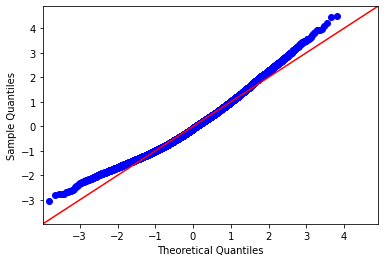

In [67]:
residuals = homoscedastic_sum.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, 
                        line = '45', fit=True)
fig.show()